This notebook gives an example of how one can analyze different runs in the same database. 
This is for instance relevant if multiple analysis with veiligheidsrendement are made for the same traject.

### Import necessary libraries

In [1]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.stats import norm
from peewee import fn
from collections import defaultdict
from vrtool.orm.models import *
from vrtool.orm.orm_controllers import open_database
from vrtool.common.enums import MechanismEnum
from postprocessing.common_functions.database_analytics import *
from postprocessing.common_functions.database_access_functions import * 
from postprocessing.generate_output import *

sns.set(style="whitegrid")
colors = sns.color_palette("colorblind", 10)



### Get the runs that are in the database
First we get an overview of the runs in the database

In [2]:
database_path = Path(r'c:\Users\klerk_wj\OneDrive - Stichting Deltares\00_Projecten\11_VR_HWBP\02_Presentaties\Dashboard cases\24-3_met_projecten\24-3_database_test_discounting.db')
casename = 'new_discounting'
run_list = get_overview_of_runs(database_path)
run_list = [run for run in run_list if run['optimization_type_name']== 'VEILIGHEIDSRENDEMENT']
pd.DataFrame(run_list)
run_list = run_list[0:4]

For each run, we get the optimization steps and the step with minimal total cost

In [3]:
optimization_steps = {run['name']: get_optimization_steps_for_run_id(database_path, run['id']) for run in run_list}
# add total cost as sum of total_lcc and total_risk in each step

minimal_tc_steps = {run: get_minimal_tc_step(steps) for run, steps in optimization_steps.items()}


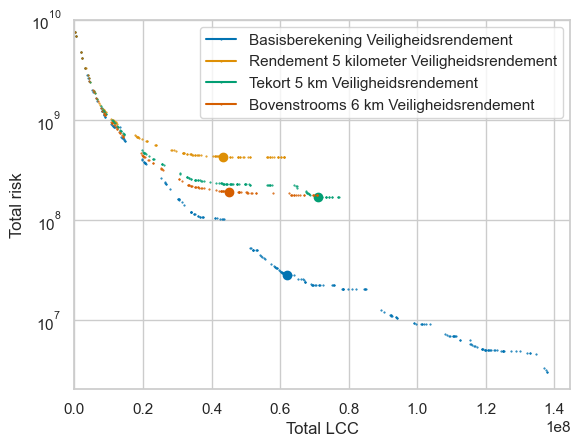

In [4]:
fig, ax = plt.subplots()
for run in optimization_steps.keys():
    plot_lcc_tc_from_steps(optimization_steps[run], axis=ax, lbl  = run, clr = colors[0])
    ax.plot(optimization_steps[run][minimal_tc_steps[run]]['total_lcc'], optimization_steps[run][minimal_tc_steps[run]]['total_risk'], 'o', color = colors.pop(0))
ax.set_xlabel('Total LCC')
ax.set_ylabel('Total risk')
ax.set_yscale('log')
ax.set_xlim(left=0)
ax.set_ylim(top=1e10)
ax.legend()
plt.savefig(database_path.parent.joinpath(f'{casename}_lcc_risk.png'),dpi=300,bbox_inches='tight')

Based on this graph we already get a good idea of which run leads to the most optimal solution (low risk - low cost).

### Reading measures per step
The next step is to read the measures and parameters of these measures for each optimization step such that we can compare the measures that are taken in each step and for each section.

In [5]:
lists_of_measures = {run['id']: get_measures_for_run_id(database_path, run['id']) for run in run_list}

measures_per_step = {run['id']: get_measures_per_step_number(lists_of_measures[run['id']]) for run in run_list}

If we want to see the failure probability per stap we first need to load the original assessment for each mechanism, and then we can compute the reliability for each step during the optimization. 

In [6]:
assessment_results = {mechanism: import_original_assessment(database_path, mechanism) 
                      for mechanism in [MechanismEnum.OVERFLOW, MechanismEnum.PIPING, MechanismEnum.STABILITY_INNER]}

reliability_per_step = {run['id']: get_reliability_for_each_step(database_path, measures_per_step[run['id']]) for run in run_list}

Based on these inputs we can make a stepwise_assessment based on the investments in reliability_per_step

In [7]:
stepwise_assessment = {run['id']: assessment_for_each_step(copy.deepcopy(assessment_results), reliability_per_step[run['id']]) for run in run_list}

The next step is to derive the traject probability for each mechanism for each step using the `calculate_traject_probability_for_steps` function

In [8]:
traject_prob = {run['id']: calculate_traject_probability_for_steps(stepwise_assessment[run['id']]) for run in run_list}

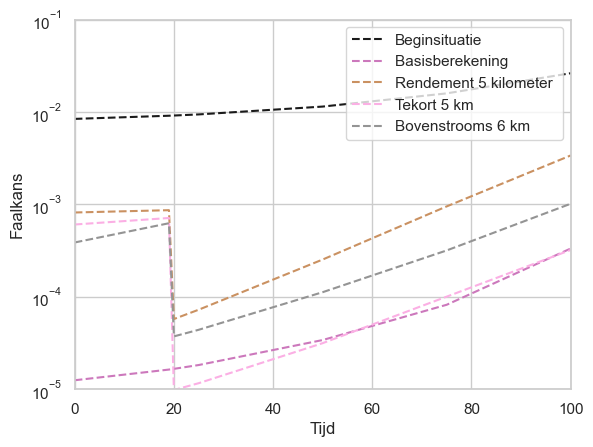

In [9]:
fig, ax  = plt.subplots()

plot_traject_probability_for_step(traject_prob[1][0], ax, run_label='Beginsituatie',color = 'k')
for count, run in enumerate(run_list):
    plot_traject_probability_for_step(traject_prob[run['id']][minimal_tc_steps[run['name']]], ax, run_label=run['name'].strip('Veiligheidsrendement'), color = colors[count])

ax.set_ylim(bottom = 1e-5, top = 1e-1)
ax.set_xlim(left = 0, right = 100)
plt.savefig(database_path.parent.joinpath(f'{casename}_traject_prob_in_time.png'),dpi=300,bbox_inches='tight')

Now we check the measures for each section. We print the ids of the measures

In [10]:
measures_per_section = {run['id']: get_measures_per_section_for_step(measures_per_step[run['id']], minimal_tc_steps[run['name']]) for run in run_list}
section_names = [list(measures_per_section[run].keys()) for run in measures_per_section.keys()]
section_names = list(set([item for sublist in section_names for item in sublist]))

for section in section_names:
    for run in measures_per_section.keys():
        try:
            print(f"Section {section} in run {run} has measures {measures_per_section[run][section][0]} at time {measures_per_section[run][section][1]}")  
        except:
            print(f"Section {section} in run {run} has no measures in run {run}")

Section 1 in run 1 has measures [145, 5] at time [0, 0]
Section 1 in run 3 has measures [145, 4] at time [20, 20]
Section 1 in run 5 has measures [145, 6] at time [20, 20]
Section 1 in run 7 has measures [145, 4] at time [20, 20]
Section 2 in run 1 has measures [292, 149] at time [0, 0]
Section 2 in run 3 has measures [292, 149] at time [20, 20]
Section 2 in run 5 has measures [292, 149] at time [20, 20]
Section 2 in run 7 has measures [292, 149] at time [20, 20]
Section 3 in run 1 has measures [439, 299] at time [0, 0]
Section 3 in run 3 has measures [439, 299] at time [0, 0]
Section 3 in run 5 has measures [439, 300] at time [0, 0]
Section 3 in run 7 has measures [439, 299] at time [0, 0]
Section 4 in run 1 has measures [586, 442] at time [0, 20]
Section 4 in run 3 has measures [586, 442] at time [0, 0]
Section 4 in run 5 has measures [586, 442] at time [0, 0]
Section 4 in run 7 has measures [586, 442] at time [0, 0]
Section 5 in run 1 has measures [733, 590] at time [0, 0]
Section 5

Now we get for each section the parameters of the measure + timing + cost. This is stored in a `pd.DataFrame` for each run.

In [ ]:
section_parameters = defaultdict(dict)

for run in measures_per_section.keys():
    for section in measures_per_section[run].keys():
        section_parameters[run][section] = []
        for measure in measures_per_section[run][section][0]:
            parameters = get_measure_parameters(measure, database_path)
            parameters.update(get_measure_costs(measure, database_path))
            parameters.update(get_measure_type(measure, database_path))
            section_parameters[run][section].append(parameters)

measure_parameters = {run['id']: measure_per_section_to_df(measures_per_section[run['id']], section_parameters[run['id']]) for run in run_list}


We list the investment for each year for each section

## Comparison of investment in time

As multiple runs in the same database will typically study the timing of measures, as final step we make a plot of the spending of each run in time.

First we get the investment for each section.

In [ ]:
investments = {}
for run in run_list:
    investments[run['name']] = {}
    years = get_unique_years(measures_per_section[run['id']])
    for section in measures_per_section[run['id']].keys():
        investments[run['name']][section] = {}
        for idx, measure in enumerate(section_parameters[run['id']][section]):
            investments[run['name']][section][measures_per_section[run['id']][section][1][idx]] = measure['cost']

Next we sum this to the total investment for each year, and make a plot

In [ ]:
total_investments_per_year = {}
for run in run_list:
    #make empty dict with keys = unique years and values = 0
    total_investments_per_year[run['name']] = dict.fromkeys(get_unique_years(measures_per_section[run['id']]), 0)
    for section in investments[run['name']].keys():
        for year in investments[run['name']][section].keys():
            total_investments_per_year[run['name']][year] += investments[run['name']][section][year]

    

In [ ]:
#make a bar plot of the investments per year, grouped by run don't stack them, add a legend
fig, ax = plt.subplots()
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
x_ticks = []
x_ticklabels = []
for count, run in enumerate(run_list):
    #x-position is a unique value per case, y-position is the cost, we plot the years next to each other
    x = [count + 0.1*idx for idx, year in enumerate(total_investments_per_year[run['name']].keys())]
    y = list(total_investments_per_year[run['name']].values())
    for idx, year in enumerate(total_investments_per_year[run['name']].keys()):
        if count == 0:
            ax.bar(x[idx], y[idx], color = colors[idx], width = 0.1, label = year)
        else:
            ax.bar(x[idx], y[idx], color = colors[idx], width = 0.1)
    x_ticks.append(x[0])
    x_ticklabels.append(run['name'].strip('Veiligheidsrendement'))   

# change x-ticks t combiatnions of axis location and run name as stored in x_ticks
ax.set_xticks(x_ticks, x_ticklabels, rotation = 90, ha = 'right', fontsize = 8)    # ax.bar(x, y, color = colors, width = 0.1, label = run['name'])
# ax.set_xticks(*x_ticks)#, rotation = 45, ha = 'right', fontsize = 8)    # ax.bar(x, y, color = colors, width = 0.1, label = run['name'])
        # ax.text(x[idx], y[idx], f'{year}', rotation = 90)
ax.legend()


